In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, date
import seaborn as sns
import scipy.stats as st
from pandas import DataFrame
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels as statm
from scipy.stats import norm, f
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
import warnings
from sklearn.linear_model import LogisticRegression
import math
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [89]:
def get_cleaned_data():
    data = pd.read_csv('/home/tal/Downloads/athletes.csv')
    data['dob'] = pd.to_datetime(data["dob"], format='%m/%d/%y')
    data['age'] = (pd.to_datetime('now') - data['dob']).astype('<m8[Y]')
    data['age'] = data['age'].astype(float)
    data = data.loc[data['age'] > 0, :]
    data = data.dropna()
    data["total"] = data[['gold', 'silver', 'bronze']].agg(sum, axis=1)
    data['gender']=data['sex'].copy()
    data['gender']= data['gender'].apply(lambda x: 1 if x=='Female' else 2)
    data['won'] = data['total'].apply(lambda x: x if x>0 else x+0.1)#1 if x == 0 else x)
    return data

In [90]:
def get_sample(data):
    winners = data.loc[data['won']>0.5, :]
    winners_sample = winners.sample(n=200, random_state=1)
    winners_sample.to_csv('winners_sample.csv')
    winners = winners[['height', 'weight', 'age', 'sport', 'sex', 'won', 'total','gender']]
    sample = data.sample(n=200, random_state=1)
    return sample

In [91]:
df = get_cleaned_data()
np.random.seed(42)
sub_df = df.sample(n=200,random_state=42)
sub_df = sub_df[['weight', 'gender', 'won','age']]
X = sub_df
y = sub_df['age']
X = sm.add_constant(X)
beta = np.linalg.inv(X.T @ X) @ X.T @ y
predictions = np.dot(X, beta)
beta =[27.983130,0.060873,0.000,0.777799]

## **Questions 1+2**

### Section A

In [92]:
def SE_NormalCov():
    l = beta - 1.96 * np.sqrt(np.diag(np.linalg.inv(X.T @ X)))
    u = beta + 1.96 * np.sqrt(np.diag(np.linalg.inv(X.T @ X)))
    indices = list(range(4))
    for i in indices:
        print(f'\nBeta - {i}')
        print(f"CI Normal Aproximation by Covariance Matrix = [ {l[i]}, {u[i]}]")
        print(f'CI Length: {u[i] - l[i]}')
        print(f"CI contains the value of regression coeffision : {l[i] <= beta[i] <= u[i]}")
        
SE_NormalCov()


Beta - 0
CI Normal Aproximation by Covariance Matrix = [ 27.973849590663498, 27.9924104093365]
CI Length: 0.01856081867300219
CI contains the value of regression coeffision : True

Beta - 1
CI Normal Aproximation by Covariance Matrix = [ -0.45510838302468976, 0.5768543830246897]
CI Length: 1.0319627660493795
CI contains the value of regression coeffision : True

Beta - 2
CI Normal Aproximation by Covariance Matrix = [ -0.34657757657773636, 0.34657757657773636]
CI Length: 0.6931551531554727
CI contains the value of regression coeffision : True

Beta - 3
CI Normal Aproximation by Covariance Matrix = [ 0.7507813443261425, 0.8048166556738575]
CI Length: 0.054035311347715
CI contains the value of regression coeffision : True


### Section B 

In [93]:
def SE_NormalBootstrap(sub_df, n_bootstraps=400):
    beta_bootstraps = []
    for i in range(n_bootstraps):
        sub_df_boot = sub_df.sample(n=200, replace=True, random_state=i)
        X_boot = sub_df_boot
        y_boot = sub_df_boot['age']
        X_boot = X_boot.drop(['age'], axis=1)
        X_boot = sm.add_constant(X_boot)
        beta_bootstraps.append(np.linalg.pinv(X_boot.T @ X_boot) @ X_boot.T @ y_boot)
    return np.array(beta_bootstraps)

se_boot = np.std(SE_NormalBootstrap(sub_df))
l = beta - 1.96 * se_boot
u = beta + 1.96 * se_boot
indices = list(range(4))
for i in indices:
    print(f'\nBeta - {i}')
    print(f"CI Normal Aproximation by Bootstrap = [ {l[i]}, {u[i]}]")
    print(f'CI Length: {u[i] - l[i]}')
    print(f"CI contains the value of regression coeffision : {l[i] <= beta[i] <= u[i]}")
    
# l = np.quantile(se_boot, 0.025, axis=0)
# u = np.quantile(se_boot, 1 - 0.025, axis=0)
# lower_bound = np.quantile(se_boot, 0.025)
# upper_bound = np.quantile(se_boot, 0.975)
# CI_pivotal = [plugIn_estimator * 2 - upper_bound, plugIn_estimator * 2 + lower_bound]

# # CI_quantile = [lower_bound,upper_bound]

# indices = range(len(beta))
# for i in indices:
#     print(f"CI Pivotal by Bootstrap = [ {l[i]}, {u[i]}]")
#     print(f'\tCI Length: {u[i] - l[i]}')
#     print(f"\tCI contains the value of regression coeffision : {l[i] <= beta[i] <= u[i]}")
    




Beta - 0
CI Normal Aproximation by Bootstrap = [ 14.617303090553914, 41.34895690944609]
CI Length: 26.731653818892173
CI contains the value of regression coeffision : True

Beta - 1
CI Normal Aproximation by Bootstrap = [ -13.304953909446084, 13.426699909446086]
CI Length: 26.73165381889217
CI contains the value of regression coeffision : True

Beta - 2
CI Normal Aproximation by Bootstrap = [ -13.365826909446085, 13.365826909446085]
CI Length: 26.73165381889217
CI contains the value of regression coeffision : True

Beta - 3
CI Normal Aproximation by Bootstrap = [ -12.588027909446085, 14.143625909446085]
CI Length: 26.73165381889217
CI contains the value of regression coeffision : True


### Section C - Pivotal Bootstrap 

In [94]:
def SE_NormalBootstrap(sub_df, n_bootstraps=400):
    beta_bootstraps = []
    for i in range(n_bootstraps):
        sub_df_boot = sub_df.sample(n=200, replace=True, random_state=i)
        X_boot = sub_df_boot[['weight','gender','won']].to_numpy()
        y_boot = sub_df_boot['age'].to_numpy()
        X_boot = np.concatenate([np.ones((X_boot.shape[0],1),dtype=X_boot.dtype), X_boot], axis=1)
        beta_bootstraps.append(np.linalg.pinv(X_boot.T @ X_boot) @ X_boot.T @ y_boot)
    return np.array(beta_bootstraps)

se_boot = SE_NormalBootstrap(sub_df)
l = np.quantile(se_boot, 0.025, axis=0)
u = np.quantile(se_boot, 1 - 0.025, axis=0)

indices = range(len(beta))
for i in indices:
    print(f'\nBeta - {i}')
    print(f"CI Pivotal by Bootstrap = [ {l[i]}, {u[i]}]")
    print(f'CI Length: {u[i] - l[i]}')
    print(f"CI contains the value of regression coeffision : {l[i] <= beta[i] <= u[i]}")
    



Beta - 0
CI Pivotal by Bootstrap = [ 5.168647785170109, 6.325045226042504]
CI Length: 1.1563974408723947
CI contains the value of regression coeffision : False

Beta - 1
CI Pivotal by Bootstrap = [ 0.0153541343168737, 0.09528089785434637]
CI Length: 0.07992676353747268
CI contains the value of regression coeffision : True

Beta - 2
CI Pivotal by Bootstrap = [ 10.337295570339442, 12.650090452085117]
CI Length: 2.312794881745674
CI contains the value of regression coeffision : False

Beta - 3
CI Pivotal by Bootstrap = [ -1.6020634417396682, 2.007269006809912]
CI Length: 3.6093324485495804
CI contains the value of regression coeffision : True


### Section D - Quantile Bootstrap

In [95]:
def SE_NormalBootstrap(sub_df, n_bootstraps=400):
    beta_bootstraps = []
    for i in range(n_bootstraps):
        sub_df_boot = sub_df.sample(n=200, replace=True, random_state=i)
        X_boot = sub_df_boot[['weight','gender','won']].to_numpy()
        y_boot = sub_df_boot['age'].to_numpy()
        X_boot = np.concatenate([np.ones((X_boot.shape[0],1),dtype=X_boot.dtype), X_boot], axis=1)
        beta_bootstraps.append(np.linalg.pinv(X_boot.T @ X_boot) @ X_boot.T @ y_boot)
    return np.array(beta_bootstraps)

se_boot = SE_NormalBootstrap(sub_df)
l = np.quantile(se_boot, 0.05, axis=0)
u = np.quantile(se_boot, 1 - 0.005, axis=0)
indices = range(len(beta))
for j in indices:
    print(f'\nBeta - {j}')
    print(f"CI Quantile by Bootstrap = [ {l[j]}, {u[j]}]")
    print(f'CI Length: {u[j] - l[j]}')
    print(f"CI contains the value of regression coeffision : {l[j] <= beta[j] <= u[j]}")


Beta - 0
CI Quantile by Bootstrap = [ 5.248274585937316, 6.527355723558058]
CI Length: 1.279081137620742
CI contains the value of regression coeffision : False

Beta - 1
CI Quantile by Bootstrap = [ 0.02108120724105936, 0.10698653376010007]
CI Length: 0.08590532651904072
CI contains the value of regression coeffision : True

Beta - 2
CI Quantile by Bootstrap = [ 10.49654917187418, 13.05471144711701]
CI Length: 2.558162275242829
CI contains the value of regression coeffision : False

Beta - 3
CI Quantile by Bootstrap = [ -1.382379205647817, 2.473603409116385]
CI Length: 3.8559826147642022
CI contains the value of regression coeffision : True


## **Question 3**

## **3.a**

In [96]:
subtracted_df = df.drop(sub_df.index)[['weight', 'gender', 'won','age']]
sub_df_new = subtracted_df.sample(n=100,random_state=42)
X_new = sub_df_new[['weight','gender','won']].to_numpy()
y_new = sub_df_new[['age']].to_numpy()
X_new = np.concatenate([np.ones((X_new.shape[0],1),dtype=X_new.dtype), X_new], axis=1)
y_new_pred = X_new @ beta
print(f"Y new - Ages prediction for sample of size 100: ")
y_new_pred

Y new - Ages prediction for sample of size 100: 


array([33.8438449, 32.2002739, 31.4089249, 32.2611469, 33.082912 ,
       32.352436 , 33.204658 , 33.5394799, 32.8090039, 33.7220989,
       32.5655119, 31.7741629, 34.7569399, 31.4697979, 34.4525749,
       32.9307499, 34.2699559, 30.7393219, 34.178626 , 33.7220989,
       32.2002739, 32.0176549, 33.7220989, 32.9307499, 33.6612259,
       32.9916229, 32.0785279, 33.752515 , 33.7220989, 33.9655909,
       32.3220199, 33.509023 , 32.8698769, 31.2263059, 34.909102 ,
       33.1133689, 32.1394009, 34.530314 , 32.2611469, 31.4697979,
       31.9567819, 32.595928 , 32.413309 , 31.6524169, 33.4177339,
       32.6263849, 31.4697979, 32.7481309, 32.1394009, 34.1482099,
       32.2002739, 33.2351149, 31.7132899, 31.8350359, 34.5743209,
       32.291563 , 33.5394799, 32.6263849, 32.5655119, 31.5915439,
       31.8959089, 32.5046389, 32.1394009, 30.9828139, 32.413309 ,
       31.6524169, 32.5046389, 32.0176549, 32.9307499, 31.3480519,
       32.0176549, 32.4437659, 32.5655119, 32.2002739, 33.2959

### **3.b + 3.c**

In [97]:
def bootstrap_3(X_new):
    bootstrap_new_predicted = []
    for i in range(400):
        sub_df_boot = sub_df_new.sample(n=200, replace=True)
        X_boot = sub_df_boot[['weight','gender','won']].to_numpy()
        y_boot = sub_df_boot['age'].to_numpy()
        X_boot = np.concatenate([np.ones((X_boot.shape[0],1),dtype=X_boot.dtype), X_boot], axis=1)
        boot_beta = np.linalg.pinv(X_boot.T @ X_boot) @ X_boot.T @ y_boot
        y_new_hat_boot = np.matmul(X_new, boot_beta)
        bootstrap_new_predicted.append(y_new_hat_boot)
    
    return np.array(bootstrap_new_predicted)

bootstrap_y_news_hat = bootstrap_3(sub_df_new)
bootstrapCI_lower = np.quantile(bootstrap_y_news_hat, 0.025, axis=0) 
bootstrapCI_upper = np.quantile(bootstrap_y_news_hat, 0.975, axis=0)
print('Examine first 5 new samples,the resulted CIs for E [ y_new | X_new ] are - \n')
for i in range(5):
    print(f"bootstrapCI[{i}] = [{bootstrapCI_lower[i]}, {bootstrapCI_upper[i]}]")

y_in_CI = np.mean(np.logical_and(bootstrapCI_lower <= bootstrap_y_news_hat,
                                                 bootstrap_y_news_hat <= bootstrapCI_upper))

print(f"\nThe proportion of times y is within the CI is {y_in_CI} %")

Examine first 5 new samples,the resulted CIs for E [ y_new | X_new ] are - 

bootstrapCI[0] = [547.9359370985566, 792.7331721983198]
bootstrapCI[1] = [388.01628712673175, 571.931064471052]
bootstrapCI[2] = [302.56620046692717, 474.7832679058889]
bootstrapCI[3] = [399.39968386459566, 574.8210421168634]
bootstrapCI[4] = [428.22840692219864, 600.8482529284596]

The proportion of times y is within the CI is 0.95 %


### 3.d

Bootstrap approximation for variance y_new by variance of bootstrap std of $\hat{y_{new}}$.

Approximate epsilon - $\hat{\sigma_{\epsilon}^2}$

Linear Regression Model Assumption -
$y_i = {\beta^*}^T X_i + \epsilon_i = \hat{y_i} + \epsilon_i$. 

As we saw in class turorial, increasing the CI length can be constructed by adding the estimator to data variance to the regression model.
Hence, for the construction of the CI based on the Boostrap procedure with total of B bootstrap steps, in each sample do:
first, $\hat{\beta}$, $\hat{y_{new}}$ then calculate the residuals.
forword,  compute the variance of the calculated residuals,and let the last be the appromixation of $\hat{\sigma_{\epsilon_{new}}^2}$.
We will end up with the CI of : 
 $\hat{y_{new}} \pm Z_{\alpha/2}\cdot \sqrt{Var(\hat{y_{new}}+\hat{\sigma_{\epsilon_{new}}^2})}$   

# **Part B**

 Q2.1 **נבדוק האם יש קשר בין האופן בו מתפלג הגובה בין ספורטאים ממין אישה וספורטאים גברים. כלומר, האם ערכי ההתפלגות עבור גובהן של גברים גבוה מאלו של גברים?**

**Q2.2**

In [98]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.gofplots import qqplot
from IPython.display import display
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import norm
import math
import random
import numpy as np
import pandas as pd
import scipy.stats as stat
import warnings
from datetime import datetime, date
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import pylab

In [99]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
def won_medal(row):
    if row['gold'] == 1:
        return 1
    if row['silver'] == 1:
        return 1
    if row['bronze'] == 1:
        return 1
    return 0

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#athlete_data = pd.read_csv("./athletes.csv")
#countries = pd.read_csv("./countries.csv")
athlete_data = pd.read_csv('/home/tal/Downloads/athletes.csv')
countries = pd.read_csv("/home/tal/Downloads/countries.csv")
#renaming the "code" column in "countries" table in order to join the tables later
countries.rename(columns={'code':'nationality'}, inplace=True)
#joining the table on "nationality" column
athlete_data = pd.merge(athlete_data, countries,on='nationality')
#changing "sex" column to binary data
athlete_data['sex'] = athlete_data.sex.map(dict(female=1, male=0))
#creating a column indicating wether the athlete won any medal
athlete_data['won_any_medal'] = athlete_data.apply(lambda row: won_medal(row), axis=1)
#converting the "dob" column to datetime
athlete_data['dob'] = pd.to_datetime(athlete_data.dob)
athlete_data['dob'] = athlete_data['dob'].mask(athlete_data['dob'].dt.year > 2016,
                                               athlete_data['dob'] - pd.DateOffset(years=100))
athlete_data_all = athlete_data
athlete_data_all = athlete_data_all.dropna()
np.random.seed(20)
athlete_data = athlete_data.sample(n=200).reset_index()
display(athlete_data)

,index,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze,country,population,gdp_per_capita,won_any_medal
0,1980,153689574,Richelle Stephens,USA,1,1996-07-22,1.68,65.0,rugby sevens,0,0,0,United States,3.214188e+08,56115.718426,0
1,5544,722113054,Roberti Kobliashvili,GEO,0,1993-12-06,1.80,85.0,wrestling,0,0,0,Georgia,3.679000e+06,3795.973308,0
2,7575,89640785,Chao Xu,CHN,0,1994-11-05,1.85,82.0,cycling,0,0,0,China,1.371220e+09,8027.683810,0
3,4723,979280840,Mariya Dmitriyenko,KAZ,1,1988-03-24,1.67,56.0,shooting,0,0,0,Kazakhstan,1.754413e+07,10509.981070,0
4,10744,973792476,Wilfried Bingangoye,GAB,0,1985-03-25,1.72,80.0,athletics,0,0,0,Gabon,1.725292e+06,8266.445605,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,5188,427314005,Fernando Saraiva Reis,BRA,0,1990-03-10,1.85,155.0,weightlifting,0,0,0,Brazil,2.078475e+08,8538.589975,0
196,6479,419664403,Karen Tebar,FRA,1,1964-09-19,1.59,57.0,equestrian,0,0,0,France,6.680838e+07,36205.568102,0
197,10353,285629214,Shun Xie Teo,SIN,1,1988-09-30,1.68,63.0,shooting,0,0,0,Singapore,5.535002e+06,52888.744672,0
198,2894,424746712,Omar Hajjami,MAR,0,1990-07-31,1.60,58.0,taekwondo,0,0,0,Morocco,3.437751e+07,2878.201342,0


### **Q2.3:**

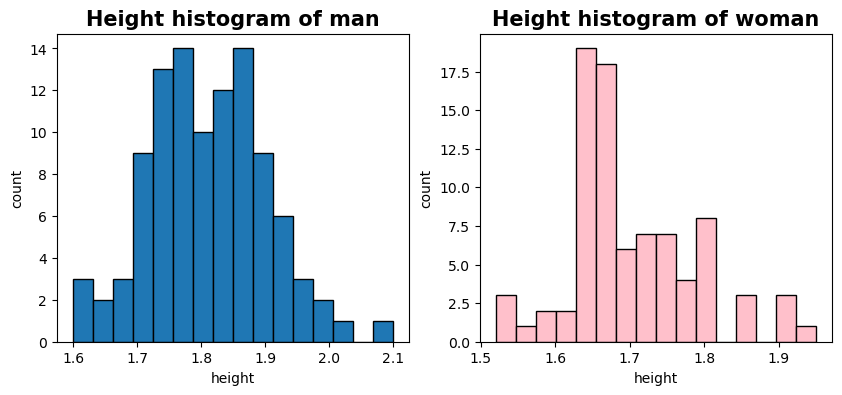

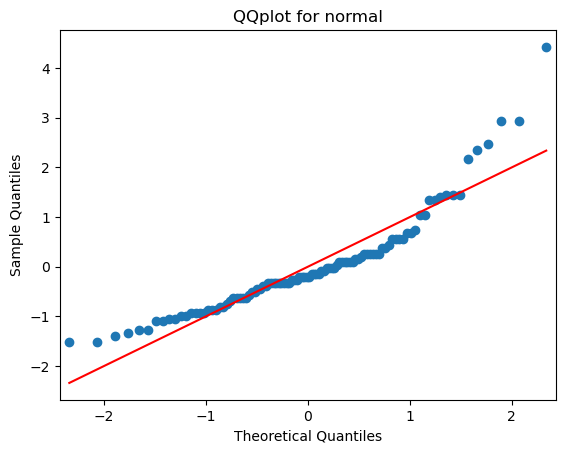

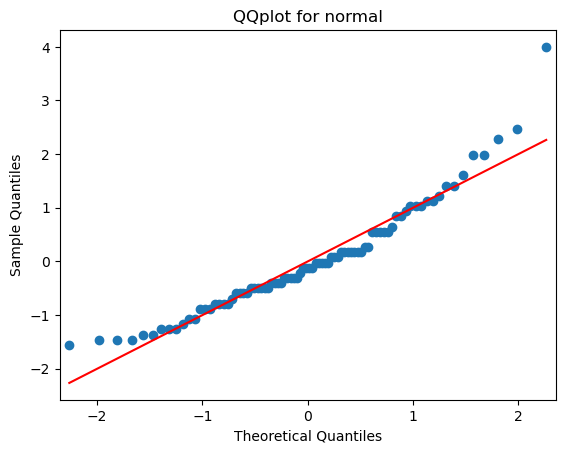

Mu1 estimator : 1.703, Mu2 estimator : 1.81, delta = 0.107


In [100]:
#drop na in athelete data
athlete_data = athlete_data.dropna()
#drop na in sample data
sample_data = athlete_data.dropna()
sum_woman = 0
sum_man = 0
count_woman = 0
count_man = 0
sex_height_df = athlete_data[['sex','id', 'height']].replace({'male': 0, 'female': 1})
woman = sex_height_df.loc[sex_height_df["sex"] == 1, :]
woman = woman.dropna()
womans_height_array = woman['height'].to_numpy()
man = sex_height_df.loc[sex_height_df["sex"] == 0, :]
man = man.dropna()
mans_height_array = man['height'].to_numpy()

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,4))

man['height'].hist(edgecolor = "black", grid = False, bins = 16, ax = ax1)
ax1.set_title("Height histogram of man", size = 15, fontweight = "bold")
ax1.set_xlabel("height")
ax1.set_ylabel("count")

woman['height'].hist(edgecolor = "black", grid = False, bins = 16, ax = ax2, color = "pink")
ax2.set_title("Height histogram of woman", size = 15, fontweight = "bold")
ax2.set_xlabel("height")
ax2.set_ylabel("count")

plt.show()
#part a
#make QQPLOT of height vs woman
won_weights = np.array(athlete_data.loc[athlete_data['sex'] == 0]['weight'], dtype=float)
qqplot(won_weights, stat.norm, fit=True, line='s')
plt.title('QQplot for normal')
plt.show()
#make QQplot of height vs man
won_weights = np.array(athlete_data.loc[athlete_data['sex'] == 1]['weight'], dtype=float)
qqplot(won_weights, stat.norm, fit=True, line='s')
plt.title('QQplot for normal')
plt.show()
height_woman = sample_data.loc[sample_data['sex'] == 1]['height']
height_man = sample_data.loc[sample_data['sex'] == 0]['height']
mu1_hat = np.mean(womans_height_array)
mu2_hat = np.mean(mans_height_array)
delta_hat = mu2_hat - mu1_hat
print(f'Mu1 estimator : {round(mu1_hat, 3)}, Mu2 estimator : {round(mu2_hat, 3)}, delta = {round(delta_hat, 3)}')

**אנו רואים כי הגובה מתפלג נורמלית בקירוב בקרב שתי הקטגוריות במדגם של ה-200 דוגמאות ולכן נוכל להניח נורמליות ולהשתמש בממוצע כאומד נראות מרבית עבור התוחלת. האומד לדלתא הוא אומד נראות מירבית כיוון שהוא פונקציה לינארית של שני אומדי נראות מרבית.**

In [101]:
#part b
var_woman_avg = np.var(womans_height_array)/len(womans_height_array)
var_man_avg = np.var(mans_height_array)/len(mans_height_array)
se_omed_height = np.sqrt(var_woman_avg + var_man_avg)
CI = [delta_hat - 1.96*se_omed_height, delta_hat + 1.96*se_omed_height]
print(f'CI for the difference in means on the sample: {CI}')

CI for the difference in means on the sample: [0.08146863839573146, 0.13284508709446377]


In [102]:
#part c
all_woman_heights = athlete_data_all.loc[athlete_data_all['sex'] == 1]['height']
all_man_heights = athlete_data_all.loc[athlete_data_all['sex']== 0]['height']
mu1_hat_all = np.mean(all_woman_heights)
mu2_hat_all = np.mean(all_man_heights)
delta_hat_all = mu2_hat_all - mu1_hat_all
print(f'Delta estimate based on the full data is : {delta_hat_all}')
print(f'Is delta estimate based on the full data is in the CI? {(CI[0] <= delta_hat) and (delta_hat <= CI[1])}')

Delta estimate based on the full data is : 0.12377410468644956
Is delta estimate based on the full data is in the CI? True


**כלומר, אנו רואים כי האומד לדלתא לפי המדגם השלם נמצא ברווח סמך לדלתא על פי המדגם המצומצם של ה200 דוגמאות**

In [103]:
#part d
print("Wald test on the sample:")
Z_wald_test = stat.norm.ppf(0.95)
w_wald = delta_hat /se_omed_height
if w_wald > Z_wald_test:
    print("In Reject H0 Region, man height is stochastichally larger than womans")
else:
    print("Not in Reject H0 Region, mans height is not stochastically larger than womans")

print("Permutations test results:")
alpha = 0.05
woman_sample_len = len(womans_height_array)
counter = 0
for b in range(400):
    df_woman = athlete_data.sample(woman_sample_len)
    df_all = athlete_data.merge(df_woman, how='left', indicator=True)
    not_in_sampled = df_all[df_all["_merge"] == "left_only"]
    df_man = not_in_sampled.drop("_merge", axis=1)
    mu2_hat_temp = np.mean(df_man['height'])
    mu1_hat_temp = np.mean(df_woman['height'])
    delta_temp = mu2_hat_temp - mu1_hat_temp
    if delta_hat <= delta_temp:
        counter += 1

test_statistic = counter / 400

if test_statistic <= alpha:
    print('In Reject H0 Region, mans height is stochastichally larger than womans')

else:
    print("Not in Reject H0 Region, mans height is not stochastically larger than womans")

Wald test on the sample:
In Reject H0 Region, man height is stochastichally larger than womans
Permutations test results:
In Reject H0 Region, mans height is stochastichally larger than womans


### **Q2.4**

In [104]:
#Q2.4.1
df_woman = athlete_data[athlete_data['sex']==1]
m1 =  df_woman['height'].median()
df_man = athlete_data[athlete_data['sex']==0]
m2 =  df_man['height'].median()
delta_hat = abs(m2-m1)
woman = df_woman['height'].values
man = df_man['height'].values
print(f'Median for winners: {m1} median for losers: {m2} delta_hat: {delta_hat}')

Median for winners: 1.68 median for losers: 1.81 delta_hat: 0.13000000000000012


**כיוון שהגובה מתפלג נורמלית בקירוב בדאטה, הפרש החציונים הוא אנ"מ. **

In [105]:
#Q2.4.2
z = norm.ppf(1-alpha/2)
var_man = np.var(df_man['height']) / len(df_man)
var_woman = np.var(df_woman['height']) / len(df_woman['height'])
se_omed_heights = np.sqrt(var_man + var_woman)
down=delta_hat - z * se_omed_heights
up= delta_hat + z * se_omed_heights
print(f'Confidence interval for median delta: {(down,up)}')

#Q2.4.3
df_all_woman = athlete_data_all[athlete_data_all['sex']==1]
m1 =  df_all_woman['height'].median()
df_all_man = athlete_data_all[athlete_data_all['sex']==0]
m2 =  df_all_man['height'].median()
delta_hat_all= abs(m2-m1)
print(f'Delta estimator for all dataset: {delta_hat}')
print(f'Is the delta for full dataset in Confidence interval for 200 samples delta : {(down<delta_hat_all<up)}')

Confidence interval for median delta: (0.10431224767778453, 0.15568775232221568)
Delta estimator for all dataset: 0.13000000000000012
Is the delta for full dataset in Confidence interval for 200 samples delta : True


**כלומר, האומד שקיבלנו עבור המדגם המלא נמצא ברווח סמך של הדלתא עבור המדגם המצומצם של ה-200 דוגמאות**

In [106]:
#Q2.4.4
print("Permutations test results:")
alpha = 0.05
woman_sample_len = len(womans_height_array)
counter = 0
for b in range(400):
    df_woman = athlete_data.sample(woman_sample_len)
    df_all = athlete_data.merge(df_woman, how='left', indicator=True)
    not_in_sampled = df_all[df_all["_merge"] == "left_only"]
    df_man = not_in_sampled.drop("_merge", axis=1)
    mu2_hat_temp = np.mean(df_man['height'])
    mu1_hat_temp = np.mean(df_woman['height'])
    delta_temp = mu2_hat_temp - mu1_hat_temp
    if  delta_temp >= delta_hat:
        counter += 1

test_statistic = counter / 400

if test_statistic <= alpha:
    print('In Reject H0 Region, mans height is stochastichally larger than womans')

else:
    print("Not in Reject H0 Region, mans height is not stochastically larger than womans")

Permutations test results:
In Reject H0 Region, mans height is stochastichally larger than womans


### Q2.4.5

**לא ניתן להשתמש במבחן וואלד. לא נוכל להניח שדלתא כובע מתפלגת אסימפטוטית נורמלית שכן היא הפרש בין חציונים שאין אנו יודעים כיצד הם מתפלגים.**

**על מנת להשתמש בטי-טסט אנו צריכים שיתקיימו 4 תנאים:**
1. אי תלות בין התצפיות - מתקיים
2. נורמליות - הגובה באוכלוסיה מתפלג נורמלית לפי הבדיקה שעשינו לפני כן - מתקיים
3. יש להשתמש במדגם גדול דיו (רצוי מעל 30 דגימות) - מתקיים
4. שווייון בין השונויות של המדגמים - לא ידוע אם מתקיים.

כלומר סה"כ בהינתן הידע שיש לנו כעת לא נדע האם ניתן להשתמש במבחן טי, יש להשוות שונויות של המדגמים באמצעות מבחנים סטטיסטים על מנת להכריע

### **Q5**

In [107]:
counter=0
from scipy.stats import norm
#Q2.4.5:
print("Normal approx:")
sample_heights = sorted(athlete_data_all['height'])
def compute_sum_ranks(woman_height, sample_heights):
    sum_of_ranks = 0
    for i, sample  in enumerate(sample_heights):
        if sample in woman_height:
            if i < len(sample_heights):
                counter = 1
                sum = i+1
                while (True):
                    if sample_heights[i+counter] == sample_heights[i]:
                        sum = sum + (i+counter)
                        counter = counter+1
                    else:
                        sum_of_ranks = sum_of_ranks + (sum/counter)
                        break
                else:
                    sum_of_ranks = sum_of_ranks + (i+1)
    return sum_of_ranks

df_woman = athlete_data[athlete_data['sex'] == 1]["height"]
sum_ranks = compute_sum_ranks(df_woman, sample_heights)
N_full = len(df_woman)+len(df_man)
est_mean = len(df_woman) * (N_full + 1) / 2
est_variance = (len(df_woman) * len(df_man) * (N_full + 1) / 12)
wilcoxon_statistic = (sum_ranks - est_mean) / np.sqrt(est_variance)
Z_qua = st.norm.ppf(0.95)
print("Test statistic: ",wilcoxon_statistic )
print("z_quantile: ", Z_qua)
if wilcoxon_statistic < Z_qua:
      print('In Reject H0 Region, mans height is stochastichally larger than womans')
else:
    print("Not in Reject H0 Region, mans height is not stochastically larger than womans")

Normal approx:
Test statistic:  -21.494185260204677
z_quantile:  1.6448536269514722
In Reject H0 Region, mans height is stochastichally larger than womans


### Q6

**הראינו באופן עקבי כי התפלגות הגובה בקרב הגברים גבוה מהתפלגות הגובה בקרב הגברים. הצלחנו לדחות את השערת האפס במבחנים שלנו ולכן נוכל להגיד כי ההשערה החלופית שלנו נכונה.**

In [1]:
import pandas

In [3]:
a = pandas.DataFrame({'a':[1,2,3]})
b = pandas.DataFrame({'b':[1,4,5,8,1]})

In [5]:
set(a['a'])  set(b['b'])

{2, 3, 4, 5}